<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/crime_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 犯罪情報
- [町丁字別犯罪情報　令和３年分（累計値）](https://catalog.data.metro.tokyo.lg.jp/dataset/t000022d0000100001/resource/38bc69bc-3f83-4c70-af49-137c6b0db5e3)

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_master_file = 'crime_master.csv'
output_score_file = 'crime_score.csv'

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

In [7]:
crime_url = 'https://www.keishicho.metro.tokyo.lg.jp/about_mpd/jokyo_tokei/jokyo/ninchikensu.files/R3.csv'
df_crime = get_data_csv_url(crime_url, encoding='shift-jis')
print(df_crime.shape)

(5096, 38)


In [8]:
total_cols = [col for col in df_crime.columns if col.endswith('計')]
print(len(total_cols))

exclusion_rows = [row for row in list(df_crime['市区町丁'].unique()) if row.endswith('計')] + ['他県', '海外認知', '不明']
print(len(exclusion_rows))

6
67


In [9]:
df_crime_extract = df_crime[['市区町丁'] + total_cols]
df_crime_extract = df_crime_extract[~df_crime_extract['市区町丁'].isin(exclusion_rows)].reset_index(drop=True)
print(df_crime_extract.shape)

(5029, 7)


In [10]:
df_crime_extract['市区町村名'] = df_crime_extract['市区町丁'].str.extract('(^.*?[区市])', expand=False)
df_crime_ward = df_crime_extract[df_crime_extract['市区町村名'].fillna('').str.endswith('区')].reset_index(drop=True)
df_crime_ward['町丁目'] = df_crime_ward.apply(lambda x: x['市区町丁'].replace(x['市区町村名'], ''), axis=1)
print(df_crime_ward.shape)

assert df_crime_ward['市区町村名'].nunique() == 23

(3089, 9)


### 犯罪マスタ

In [11]:
df_crime_ward.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

### 人口マスタ

In [12]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目']]
print(df_pop_master.shape)

(3145, 4)


In [13]:
df_pop_master = pd.merge(
    df_pop_master, 
    df_crime_ward.drop(columns=['市区町丁']),
    on=['市区町村名', '町丁目'], how='left').fillna(0)
print(df_pop_master.shape)

(3145, 10)


In [14]:
df_pop_master.head()

,地域ID,市区町村名,町名,町丁目,総合計,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計
0,101003,千代田区,丸の内,丸の内１丁目,242.0,1.0,23.0,0.0,136.0,82.0
1,101004,千代田区,丸の内,丸の内２丁目,40.0,0.0,1.0,0.0,22.0,17.0
2,101005,千代田区,丸の内,丸の内３丁目,141.0,0.0,3.0,0.0,13.0,125.0
3,101007,千代田区,大手町,大手町１丁目,36.0,1.0,8.0,3.0,18.0,6.0
4,101008,千代田区,大手町,大手町２丁目,24.0,0.0,9.0,0.0,12.0,3.0


In [15]:
score_name = '治安スコア'
feature_list = {
    '凶悪犯計':     {'sort': -1, 'weight': 1}, 
    '粗暴犯計':     {'sort': -1, 'weight': 0.8},
    '侵入窃盗計':   {'sort': -1, 'weight': 0.6}, 
    '非侵入窃盗計': {'sort': -1, 'weight': 0.5}, 
    'その他計':     {'sort': -1, 'weight': 0.4}, 
}
all_feature_list = list(feature_list.keys())

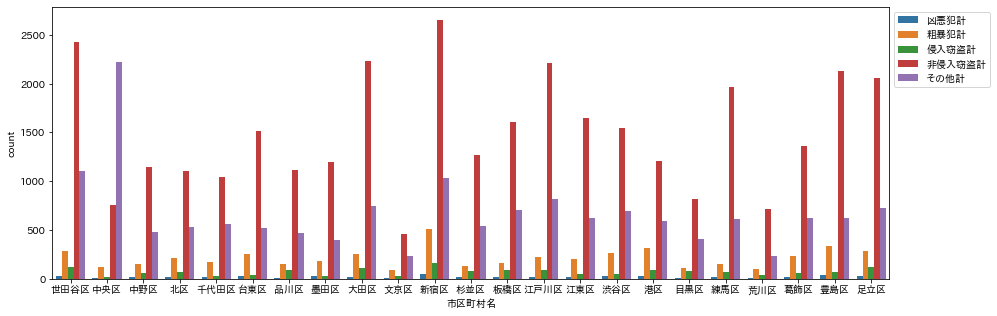

In [16]:
df_group_crime = df_pop_master.groupby('市区町村名')[all_feature_list].sum().stack().rename('count').reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(data=df_group_crime, x='市区町村名', y='count', hue='level_1')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

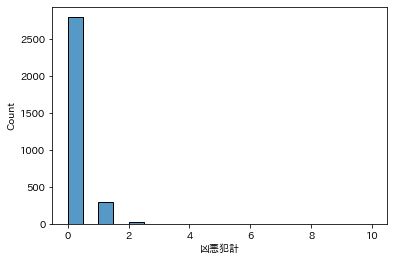

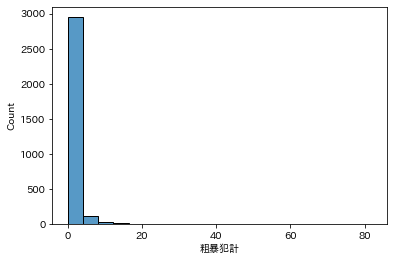

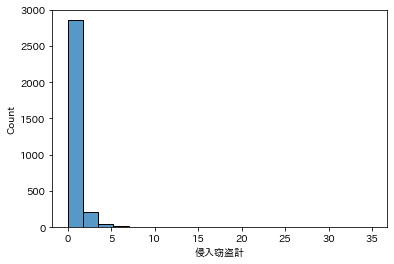

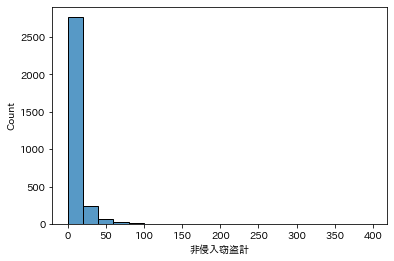

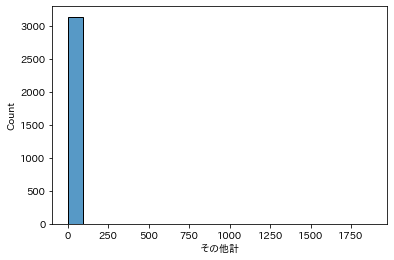

In [17]:
for feature_name in all_feature_list:
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [18]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

In [19]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score)

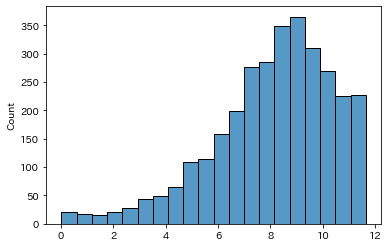

In [20]:
sns.histplot(_tmp_score, bins=20)
plt.show()

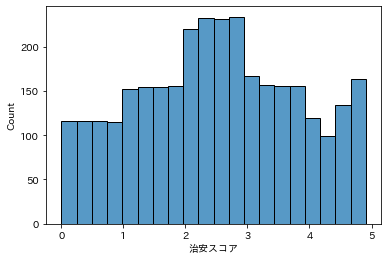

In [21]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

### 保存

In [22]:
all_feature_list

['凶悪犯計', '粗暴犯計', '侵入窃盗計', '非侵入窃盗計', 'その他計']

In [23]:
df_pop_master[score_name] = df_pop_master[score_name].round(3)

In [24]:
df_pop_master[
    ['地域ID'] + all_feature_list + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

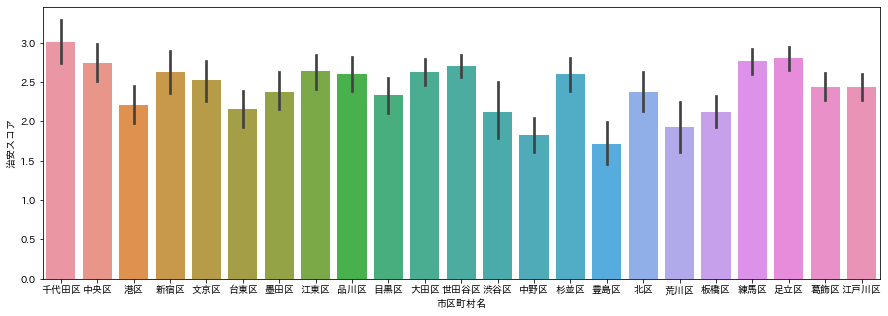

In [25]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [26]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')['治安スコア'].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values('治安スコア', ascending=False)[
     ['市区町村名', '町名', '町丁目'] + all_feature_list + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(890, 9)


In [27]:
df_level.head(10)

,市区町村名,町名,町丁目,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計,治安スコア
0,新宿区,神楽坂,神楽坂３丁目,0.0,0.0,0.0,0.0,0.0,4.908
1,大田区,羽田沖水面,羽田沖水面,0.0,0.0,0.0,0.0,0.0,4.908
2,足立区,東伊興,東伊興４丁目,0.0,0.0,0.0,0.0,0.0,4.908
3,千代田区,神田北乗物町,神田北乗物町,0.0,0.0,0.0,0.0,0.0,4.908
4,足立区,入谷,入谷６丁目,0.0,0.0,0.0,0.0,0.0,4.908
5,千代田区,神田美倉町,神田美倉町,0.0,0.0,0.0,0.0,0.0,4.908
6,千代田区,神田東紺屋町,神田東紺屋町,0.0,0.0,0.0,0.0,0.0,4.908
7,新宿区,戸塚町,戸塚町１丁目,0.0,0.0,0.0,0.0,0.0,4.908
8,大田区,東海,東海５丁目,0.0,0.0,0.0,0.0,0.0,4.908
9,新宿区,改代町,改代町,0.0,0.0,0.0,0.0,0.0,4.908


In [28]:
df_level.tail(10)

,市区町村名,町名,町丁目,凶悪犯計,粗暴犯計,侵入窃盗計,非侵入窃盗計,その他計,治安スコア
880,新宿区,富久町,富久町,0.0,7.0,7.0,21.0,11.0,0.299
881,世田谷区,三軒茶屋,三軒茶屋１丁目,0.0,5.0,3.0,31.0,20.0,0.293
882,足立区,千住旭町,千住旭町,0.0,16.0,2.0,59.0,13.0,0.263
883,新宿区,大久保,大久保２丁目,0.0,6.0,3.0,52.0,17.0,0.252
884,板橋区,幸町,幸町,2.0,2.0,1.0,19.0,6.0,0.201
885,板橋区,大山東町,大山東町,1.0,2.0,3.0,30.0,15.0,0.127
886,渋谷区,宇田川町,宇田川町,2.0,47.0,0.0,211.0,54.0,0.121
887,渋谷区,円山町,円山町,4.0,15.0,1.0,35.0,11.0,0.076
888,渋谷区,道玄坂,道玄坂２丁目,6.0,37.0,1.0,155.0,59.0,0.049
889,新宿区,歌舞伎町,歌舞伎町２丁目,10.0,69.0,22.0,190.0,69.0,0.004
